# get_hrdps

This routine grabs the latest High Resolution Deterministic Prediction System (HRDPS) model data from MSC Datamart and outputs png plots into designated product folders for each ACMWF product.

**Datamart:**

https://eccc-msc.github.io/open-data/msc-data/nwp_hrdps/readme_hrdps_en/

https://dd.weather.gc.ca/model_hrdps/

**Outputs:**

Hourly Precipitation -> *BC/AB, South Coast, South Interior, Alberta Rockies, Precipitation Type

12hr Total Precipitation -> *South Coast, South Interior, Alberta Rockies*

Temperatures -> *Surface*


**Maintenance:**

For bug reports, suggestions, inquiries, contact Andrew.Loeppky@gmail.com

In [1]:
from herbie import Herbie
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "heavy"
from toolbox import EasyMap, pc
import cartopy.crs as ccrs
import cartopy.feature as feature
import pandas as pd

from matplotlib.patches import Rectangle
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pytz
import os, shutil
import json

import warnings

# supress because removal of old datafiles is handled outside herbie
warnings.filterwarnings("ignore")

from bmwflib import clear_directory, get_var, plot_cities, make_basemap

%load_ext jupyter_black

 ╭─▌▌Herbie─────────────────────────────────────────────╮
 │ WARNING: Unable to create config file               │
 │      /Users/andrew/.config/herbie/config.toml        │
 │ Herbie will use standard default settings.           │
 │ Consider setting env variable HERBIE_CONFIG_PATH.    │
 ╰──────────────────────────────────────────────────────╯



In [2]:
def plot_temps(fxx, ds, config):
    """
    plots 2m temperatures, saves hourly
    """
    # make a figure
    fig = plt.figure(figsize=(15, 15))
    fig.tight_layout()
    ax = fig.add_subplot(
        1,
        1,
        1,
        position=(0, 0, 1, 1),
        projection=ccrs.LambertConformal(
            central_longitude=-123,
            central_latitude=54.0,
        ),
    )
    ax.set_extent([-140, -110, 46, 65])

    # basemap
    make_basemap(ax)

    # configure colormaps
    t_cmap = mpl.colors.ListedColormap(
        [
            "#FFFAFA",
            "#C0C0C0",
            "#4B0082",
            "#8B008B",
            "#9400D3",
            "#9370DB",
            "#0000CD",
            "#1E90FF",
            "#00BFFF",
            "#F0E68C",
            "#FFFF00",
            "#FFA500",
            "#FF4500",
            "#d62728",
            "#FF69B4",
            "#800000",
            "#000000",
        ]
    )
    t_bounds = [
        -40,
        -35,
        -30,
        -25,
        -20,
        -15,
        -10,
        -5,
        -1,
        1,
        5,
        10,
        15,
        20,
        25,
        30,
        35,
        40,
    ]
    t_norm = mpl.colors.BoundaryNorm(t_bounds, t_cmap.N)

    # plot 2m temperature
    t2m = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.t2m,
        cmap=t_cmap,
        norm=t_norm,
        antialiased=True,
        transform=pc,
        alpha=0.8,
    )

    # shade out legend regions, AC style
    ax.add_patch(
        Rectangle(
            (0, 0), 0.12, 0.85, transform=ax.transAxes, color="steelblue", alpha=0.8
        )
    )
    ax.add_patch(
        Rectangle((0, 0.85), 1, 1, transform=ax.transAxes, color="steelblue", alpha=0.8)
    )

    # cities
    plot_cities(ax)

    # 2m temp colorbar
    fig.text(0.141, 0.689, "($^o$C)", color="black", size=10)
    fig.text(0.14, 0.69, "($^o$C)", color="white", size=10)

    t_cbar = fig.colorbar(
        t2m,
        cmap=t_cmap,
        norm=t_norm,
        ax=ax,
        spacing="uniform",
        shrink=0.6,
        location="left",
        aspect=20,
        anchor=(0.15, 0.25),
        pad=-0.18,
    )
    t_cbar.ax.set_yticks(t_bounds)
    t_cbar.ax.tick_params(
        labelsize=10,
        labelcolor="white",
        length=0,
        labelright=True,
        labelleft=False,
    )

    # timestamps
    the_date = (
        pd.Timestamp(ds.valid_time.values)
        .tz_localize("UTC")
        .tz_convert("America/Vancouver")
    )
    fmt_date = the_date.strftime("%a. %m-%d-%y \n%H:%M %p")
    fig.text(0.501, 0.809, fmt_date, color="black", size=20)
    fig.text(0.5, 0.81, fmt_date, color="white", size=20)
    fig.text(
        0.121,
        0.159,
        f"{ds.model.upper()} {pd.Timestamp(ds.time.values).strftime("%H")} Z",
        color="black",
        size=10,
    )
    fig.text(
        0.12,
        0.16,
        f"{ds.model.upper()} {pd.Timestamp(ds.time.values).strftime("%H")} Z",
        color="white",
        size=10,
    )

    # title
    fig.text(0.351, 0.809, "Temperature\n2 meters", color="black", size=20)
    fig.text(0.35, 0.81, "Temperature\n2 meters", color="white", size=20)

    # save and close figure
    fig.savefig(
        os.path.join(
            config["plots"]["surf_temp"],
            f"temp2m_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        )
    )
    fig.clf()

    return None

In [ ]:
def plot_precip1hr(fxx, ds, config):
    """
    plots 1hr precip, saves hourly to the BC/AB, south coast,
    south interior, alberta rockies folders
    """
    # make a figure
    fig = plt.figure(figsize=(15, 15))
    fig.tight_layout()
    ax = fig.add_subplot(
        1,
        1,
        1,
        position=(0, 0, 1, 1),
        projection=ccrs.LambertConformal(
            central_longitude=-123,
            central_latitude=54.0,
        ),
    )

    # basemap
    make_basemap(ax)

    # plot precip rate
    pr_cmap = mpl.colors.ListedColormap(
        [
            "#90EE90",
            "#ADFF2F",
            "#3CB371",
            "#2E8B57",
            "#FFFF00",
            "#FFA500",
            "#B22222",
            "#8B008B",
        ]
    )
    pr_bounds = [0.1, 1, 2, 5, 7.5, 10, 15, 20, 25]
    pr_labels = ["0.1", "1", "2", "5", "7.5", "10", "15", "20", "25+"]
    pr_norm = mpl.colors.BoundaryNorm(pr_bounds, pr_cmap.N)
    pr = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds["APCP-Accum1h"].where(ds["APCP-Accum1h"] >= 0.1),
        cmap=pr_cmap,
        norm=pr_norm,
        antialiased=True,
        transform=pc,
    )

    # shade out legend regions, AC style
    ax.add_patch(
        Rectangle(
            (0, 0), 0.12, 0.85, transform=ax.transAxes, color="steelblue", alpha=0.8
        )
    )
    ax.add_patch(
        Rectangle((0, 0.85), 1, 1, transform=ax.transAxes, color="steelblue", alpha=0.8)
    )

    # precip colorbar
    fig.text(0.151, 0.699, "(mm/h)", color="black", size=10)
    fig.text(0.15, 0.7, "(mm/h)", color="white", size=10)

    pr_cbar = fig.colorbar(
        pr,
        cmap=pr_cmap,
        norm=pr_norm,
        ax=ax,
        spacing="uniform",
        shrink=0.45,
        location="left",
        aspect=10,
        anchor=(0.15, 0.45),
        pad=-0.16,
    )
    pr_cbar.ax.tick_params(
        labelsize=10,
        labelcolor="white",
        length=0,
        labelright=True,
        labelleft=False,
    )
    pr_cbar.ax.set_yticklabels(pr_labels)

    # cities
    plot_cities(ax)

    # timestamps
    the_date = (
        pd.Timestamp(ds.valid_time.values)
        .tz_localize("UTC")
        .tz_convert("America/Vancouver")
    )
    fmt_date = the_date.strftime("%a. %m-%d-%y \n%H:%M %p")
    fig.text(0.551, 0.809, fmt_date, color="black", size=20)
    fig.text(0.55, 0.81, fmt_date, color="white", size=20)
    fig.text(
        0.131,
        0.159,
        f"{ds.model.upper()} {pd.Timestamp(ds.time.values).strftime("%H")} Z",
        color="black",
        size=10,
    )
    fig.text(
        0.13,
        0.16,
        f"{ds.model.upper()} {pd.Timestamp(ds.time.values).strftime("%H")} Z",
        color="white",
        size=10,
    )

    # title
    fig.text(0.301, 0.819, "Hourly Precipitation", color="black", size=20)
    fig.text(0.30, 0.82, "Hourly Precipitation", color="white", size=20)

    ax.set_extent([-140, -110, 46, 65])

    # BC/AB
    fig.savefig(
        os.path.join(
            config["plots"]["hpcp_bcab"],
            f"pcp1hr_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        )
    )

    # South Coast
    ax.set_extent([-129, -120, 47.5, 53])
    fig.savefig(
        os.path.join(
            config["plots"]["hpcp_southcoast"],
            f"pcp1hr_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        )
    )

    # South Interior
    ax.set_extent([-125, -113, 48.5, 56])
    fig.savefig(
        os.path.join(
            config["plots"]["hpcp_southint"],
            f"pcp1hr_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        )
    )

    # Alberta Rockies
    ax.set_extent([-128, -111, 48.5, 59])
    fig.savefig(
        os.path.join(
            config["plots"]["hpcp_rockies"],
            f"pcp1hr_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        )
    )
    fig.clf()

    return None

In [ ]:
def do_hrdps(run, fxx, config):
    """
    creates all hrdps dependent plots for forecast time fxx
    """
    # clear the hrdps data folder
    clear_dir = [clear_directory(file) for file in list(config["data"].values())]

    temp = get_var(run, "hrdps", fxx, "TMP", "AGL-2m")
    pcp1h = get_var(run, "hrdps", fxx, "APCP-Accum1h", "Sfc")
    pcp12h = get_var(run, "hrdps", fxx, "APCP", "Sfc")
    ptype = get_var(run, "hrdps", fxx, "PTYPE", "Sfc")
    ds = xr.merge([temp, pcp1h, pcp12h, ptype])

    # convert temps from kelvin to degC
    ds["t2m"] -= 273.15

    # generate plots
    plot_temps(fxx, ds, config)
    plot_precip1hr(fxx, ds, config)

    return None

In [9]:
def main(tstep=range(1, 49, 1)):
    """
    main function to generate all gdps plots for a forecast run
    (default 48h with 1h increments)
    """
    # time of last model run (0000, 0600, 1200, 1800 Z)
    now = pd.Timestamp.utcnow().floor("6h").tz_localize(None)

    # config determines the directories in which to save each graphic
    with open("..//config/hrdps_config.json") as f:
        config = json.load(f)

    clear_dir = [clear_directory(file) for file in list(config["plots"].values())]
    hrdps = [do_hrdps(now, fxx, config) for fxx in tstep]

    return None

In [82]:
if __name__ == "__main__":
    main(range(1, 49, 1))

✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/hrdps/20250603]
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/hrdps/20250603]
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continen

✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F11 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F11 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F11 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F12 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/hrdps/20250603]
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F12 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F12 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F12 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F13 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/hrdps/20250603]
✅ Found ┊ model=hrdps ┊ product=continen

✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F21 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F21 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F22 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/hrdps/20250603]
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F22 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F22 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F22 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F23 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/hrdps/20250603]
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F23 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continen

✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F31 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F32 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/hrdps/20250603]
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F32 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F32 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F32 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F33 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/hrdps/20250603]
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F33 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F33 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continen

✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F42 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/hrdps/20250603]
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F42 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F42 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F42 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F43 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/hrdps/20250603]
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F43 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F43 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F43 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continen

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

In [15]:
run = pd.Timestamp.utcnow().floor("6h").tz_localize(None)
with open("..//config/hrdps_config.json") as f:
    config = json.load(f)
clear_dir = [clear_directory(file) for file in list(config["data"].values())]
fxx = 1
temp = get_var(run, "hrdps", fxx, "TMP", "AGL-2m")
pcp1h = get_var(run, "hrdps", fxx, "APCP-Accum1h", "Sfc")
pcp12h = get_var(run, "hrdps", fxx, "APCP", "Sfc")
ptype = get_var(run, "hrdps", fxx, "PTYPE", "Sfc")
ds = xr.merge([temp, pcp1h, pcp12h, ptype])

# convert temps from kelvin to degC
ds["t2m"] -= 273.15

# generate plots
# plot_temps(fxx, ds, config)

✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/hrdps/20250603]
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-03 00:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


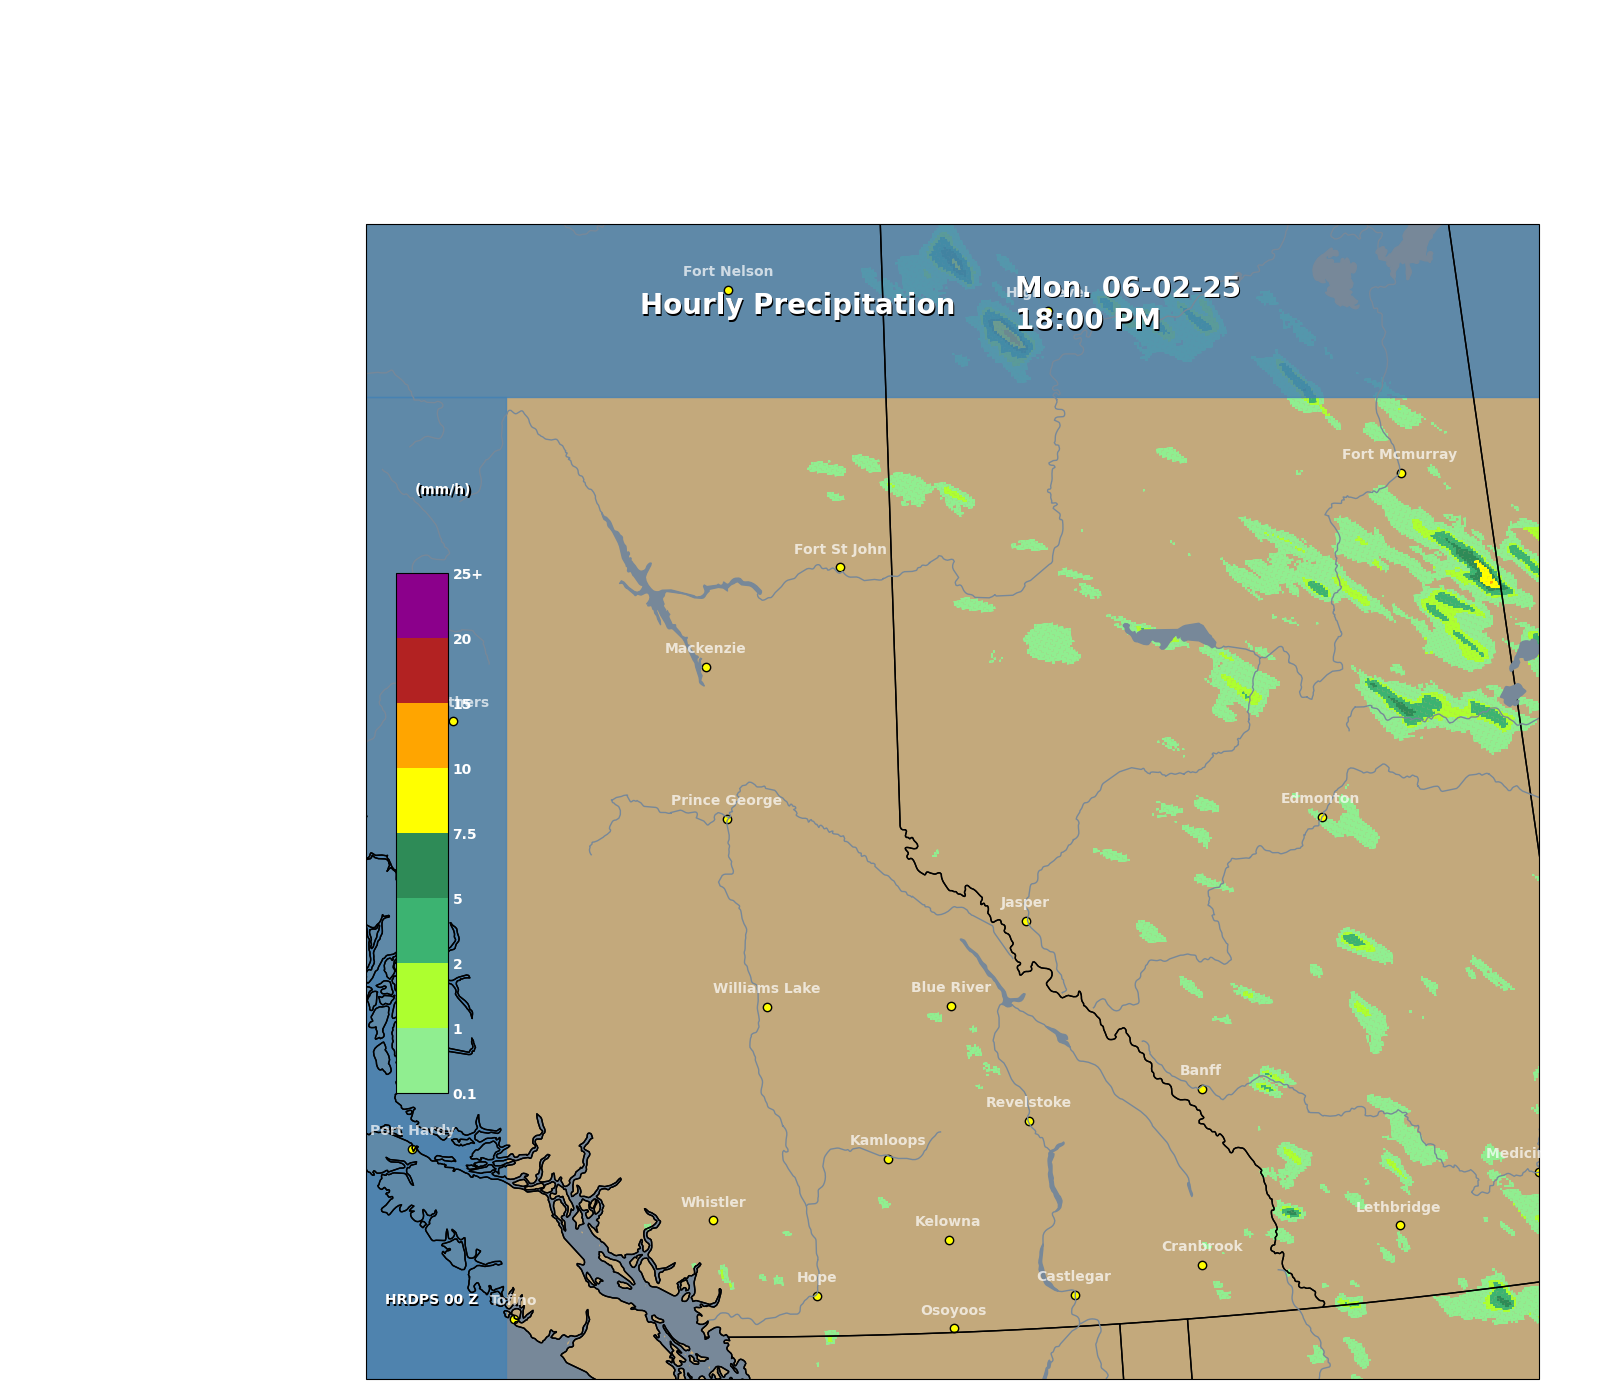

In [79]:
# make a figure
fig = plt.figure(figsize=(15, 15))
fig.tight_layout()
ax = fig.add_subplot(
    1,
    1,
    1,
    position=(0, 0, 1, 1),
    projection=ccrs.LambertConformal(
        central_longitude=-123,
        central_latitude=54.0,
    ),
)

# basemap
make_basemap(ax)

# plot precip rate
pr_cmap = mpl.colors.ListedColormap(
    [
        "#90EE90",
        "#ADFF2F",
        "#3CB371",
        "#2E8B57",
        "#FFFF00",
        "#FFA500",
        "#B22222",
        "#8B008B",
    ]
)
pr_bounds = [0.1, 1, 2, 5, 7.5, 10, 15, 20, 25]
pr_labels = ["0.1", "1", "2", "5", "7.5", "10", "15", "20", "25+"]
pr_norm = mpl.colors.BoundaryNorm(pr_bounds, pr_cmap.N)
pr = ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds["APCP-Accum1h"].where(ds["APCP-Accum1h"] >= 0.1),
    cmap=pr_cmap,
    norm=pr_norm,
    antialiased=True,
    transform=pc,
)

# shade out legend regions, AC style
ax.add_patch(
    Rectangle((0, 0), 0.12, 0.85, transform=ax.transAxes, color="steelblue", alpha=0.8)
)
ax.add_patch(
    Rectangle((0, 0.85), 1, 1, transform=ax.transAxes, color="steelblue", alpha=0.8)
)

# precip colorbar
fig.text(0.151, 0.699, "(mm/h)", color="black", size=10)
fig.text(0.15, 0.7, "(mm/h)", color="white", size=10)

pr_cbar = fig.colorbar(
    pr,
    cmap=pr_cmap,
    norm=pr_norm,
    ax=ax,
    spacing="uniform",
    shrink=0.45,
    location="left",
    aspect=10,
    anchor=(0.15, 0.45),
    pad=-0.16,
)
pr_cbar.ax.tick_params(
    labelsize=10,
    labelcolor="white",
    length=0,
    labelright=True,
    labelleft=False,
)
pr_cbar.ax.set_yticklabels(pr_labels)

# cities
plot_cities(ax)

# timestamps
the_date = (
    pd.Timestamp(ds.valid_time.values)
    .tz_localize("UTC")
    .tz_convert("America/Vancouver")
)
fmt_date = the_date.strftime("%a. %m-%d-%y \n%H:%M %p")
fig.text(0.551, 0.809, fmt_date, color="black", size=20)
fig.text(0.55, 0.81, fmt_date, color="white", size=20)
fig.text(
    0.131,
    0.159,
    f"{ds.model.upper()} {pd.Timestamp(ds.time.values).strftime("%H")} Z",
    color="black",
    size=10,
)
fig.text(
    0.13,
    0.16,
    f"{ds.model.upper()} {pd.Timestamp(ds.time.values).strftime("%H")} Z",
    color="white",
    size=10,
)

# title
fig.text(0.301, 0.819, "Hourly Precipitation", color="black", size=20)
fig.text(0.30, 0.82, "Hourly Precipitation", color="white", size=20)

ax.set_extent([-140, -110, 46, 65])

# BC/AB
fig.savefig(
    os.path.join(
        config["plots"]["hpcp_bcab"],
        f"pcp1hr_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
    )
)

# South Coast
ax.set_extent([-129, -120, 47.5, 53])
fig.savefig(
    os.path.join(
        config["plots"]["hpcp_southcoast"],
        f"pcp1hr_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
    )
)

# South Interior
ax.set_extent([-125, -113, 48.5, 56])
fig.savefig(
    os.path.join(
        config["plots"]["hpcp_southint"],
        f"pcp1hr_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
    )
)

# Alberta Rockies
ax.set_extent([-128, -111, 48.5, 59])
fig.savefig(
    os.path.join(
        config["plots"]["hpcp_rockies"],
        f"pcp1hr_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
    )
)
fig.clf()